In [8]:
import sys
sys.path.append(str(Path("..").resolve()))
import pandas as pd
import os
from pathlib import Path
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from mlforecast import MLForecast
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae
from src.data.feature_engineering import date_features, lags, partial
from src.data.data_preprocessing import prepare_df

## 1️⃣ Data preparation

In [9]:
# -------------------------------
# 1.1 Data Prepartion for Nixtla
# -------------------------------


raw_path =r'C:\Users\Guest\Desktop\ds-projects\Energy-Forecasting\data\raw\PJME_hourly.csv'


df= pd.read_csv(raw_path)  # raw CSV  
df = prepare_df(df)                      # clean, rename, add unique_id
df.head()

,ds,y,unique_id
8734,2002-01-01 01:00:00,30393.0,A
8735,2002-01-01 02:00:00,29265.0,A
8736,2002-01-01 03:00:00,28357.0,A
8737,2002-01-01 04:00:00,27899.0,A
8738,2002-01-01 05:00:00,28057.0,A


## 2️⃣ Models Training

In [10]:
# ===============================
# 
# ===============================

models = {
                'lreg': LinearRegression(),
                'dt': DecisionTreeRegressor(),
                'xgb': xgb.XGBRegressor() 
}


ml = MLForecast(
                freq='h',
                models=models,
                lags=[1, 24],
                date_features=['dayofweek', 'hour'],

)


In [11]:

cv_df = ml.cross_validation(
                h=50,
                df=df,
                n_windows=8,
                step_size=50,
                refit=True,
                static_features=[]
)
#print(f'cross validation results', cv_df.head())
print(f'✅ Models trained successfully!')
cv_df.head()

✅ Models trained successfully!


,unique_id,ds,cutoff,y,lreg,dt,xgb
0,A,2018-07-17 09:00:00,2018-07-17 08:00:00,40896.0,38553.840540,40879.0,38913.531250
1,A,2018-07-17 10:00:00,2018-07-17 08:00:00,43309.0,39327.661969,43984.0,40491.230469
2,A,2018-07-17 11:00:00,2018-07-17 08:00:00,45887.0,40570.809089,47196.0,42556.230469
3,A,2018-07-17 12:00:00,2018-07-17 08:00:00,48061.0,42123.652160,49946.0,44353.093750
4,A,2018-07-17 13:00:00,2018-07-17 08:00:00,49586.0,43852.326220,52133.0,45615.031250


## 4️⃣ Evaluation and plotting

In [12]:
from utilsforecast.evaluation import evaluate



# Calculate performance metrics
metrics = evaluate(cv_df.drop(columns=['cutoff']),
                    metrics=[mae],
                    models=['lreg', 'dt', 'xgb']
            )

metrics

,unique_id,metric,lreg,dt,xgb
0,A,mae,5300.529842,4195.5075,3016.803408


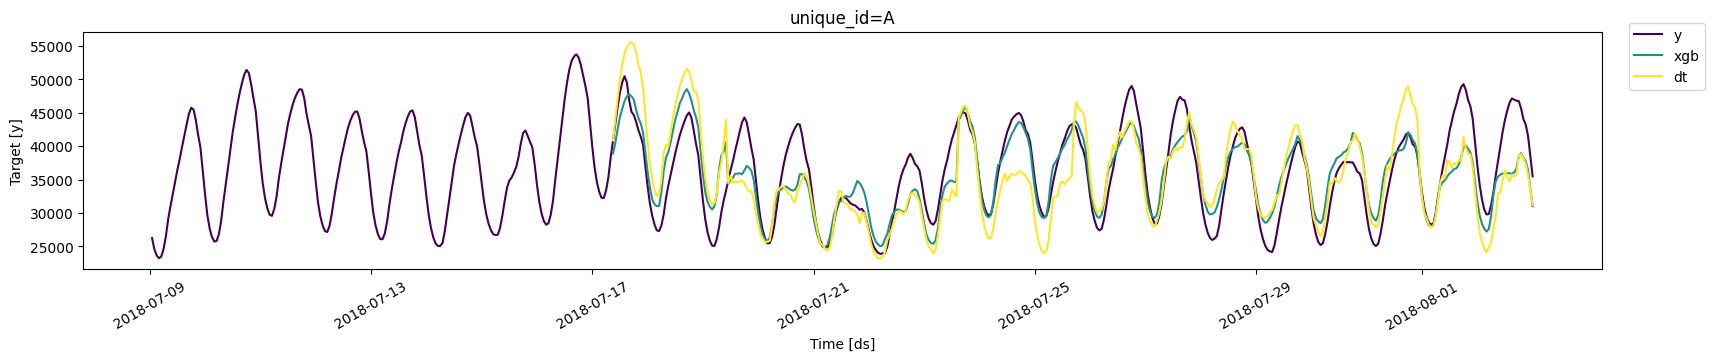

In [13]:
# 3.2 plotting

from utilsforecast.plotting import plot_series


plot_series(df=df, 
                forecasts_df= cv_df.drop(columns=['cutoff', 'y']),
                max_insample_length=600,
                palette='viridis', 
                models=['xgb','dt']
        )